In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('ACTIVE ALL.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable


In [2]:
#Explore data statistics
df.describe()

500.075    500.336    500.597    500.858    501.119    501.381  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean    7.753985   3.802339   3.836674   3.828210   3.810267   3.837984   
std    11.667057   1.014460   1.003690   1.001653   1.027369   1.039038   
min     1.865000   1.966667   1.990000   1.983333   1.966667   1.976667   
25%     2.730000   2.800000   2.840000   2.866667   2.826667   2.836667   
50%     4.066667   4.024444   4.040000   4.061111   4.112222   4.163333   
75%     4.793333   4.667778   4.713333   4.766667   4.843333   4.856667   
max    41.633333   5.720000   5.703333   5.643333   5.583333   5.596667   

         501.642    501.903    502.164    502.425  ...    948.856    949.094  \
count  81.000000  81.000000  81.000000  81.000000  ...  81.000000  81.000000   
mean    3.911591   3.934595   3.911207   3.927051  ...  27.785741  27.534787   
std     1.022691   1.020801   1.035155   1.033275  ...   7.668421   7.655677   
min     2.073333   2.103333   2.053333   2.043333  ...  15.620000  15.436667   
25%     2.920000   2.946667   2.916667   2.936667  ...  19.700000  19.526667   
50%     4.181111   4.180000   4.182222   4.193333  ...  30.960000  30.423333   
75%     4.883333   4.906667   4.916667   4.937778  ...  34.292222  33.376667   
max     5.703333   5.750000   5.770000   5.793333  ...  39.190000  39.213333   

         949.333    949.571    949.809    950.048    950.286    950.524  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean   27.605364  27.800665  27.671735  27.475460  27.455000  27.456337   
std     7.637804   7.621589   7.582618   7.596590   7.617203   7.628076   
min    15.560000  15.703333  15.583333  15.426667  15.333333  15.163333   
25%    19.613333  19.836667  19.796667  19.636667  19.583333  19.513333   
50%    30.563333  30.810000  30.456667  30.193333  30.136667  30.173333   
75%    33.716667  34.265556  34.043333  33.292222  33.338889  33.380000   
max    39.148889  39.124444  39.095556  39.100000  39.117778  39.137778   

         950.763       SPAD  
count  81.000000  81.000000  
mean   27.298855  36.073827  
std     7.677322   4.130676  
min    14.983333  28.200000  
25%    19.326667  32.900000  
50%    29.763333  35.800000  
75%    33.373333  39.930000  
max    39.124444  44.230000  

[8 rows x 1793 columns]

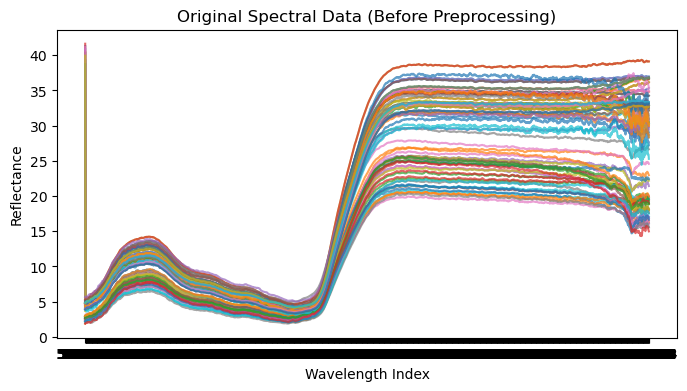

In [3]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)
plt.title('Original Spectral Data (Before Preprocessing)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 81
Number of outliers removed: 4
Cleaned dataset size: 77
Cleaned spectral data size: 77


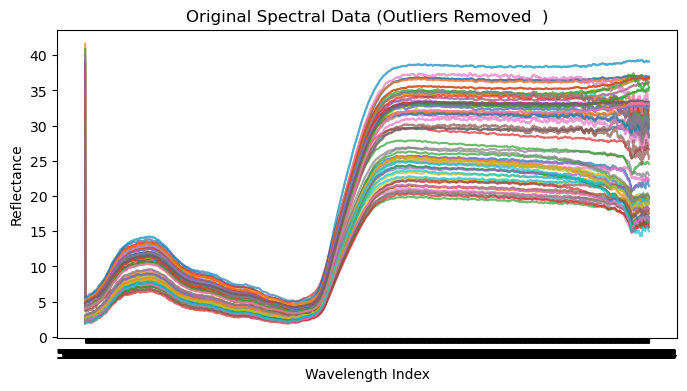

In [5]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T,alpha=0.7)
plt.title('Original Spectral Data (Outliers Removed  )')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.5
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]


Correlation values with SPAD:
500.075    0.345359
500.336    0.613563
500.597    0.619444
500.858    0.639643
501.119    0.664630
             ...   
949.809    0.721266
950.048    0.727175
950.286    0.729333
950.524    0.730780
950.763    0.734921
Name: SPAD, Length: 1792, dtype: float64
Top features correlated with SPAD:
945.278    0.737815
945.517    0.737706
950.763    0.734921
946.232    0.734595
945.755    0.732792
944.323    0.732405
946.471    0.732396
945.994    0.731797
945.039    0.731330
950.524    0.730780
Name: SPAD, dtype: float64


In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2):
    return savgol_filter(cleaned_spectral_data, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2)

#Plot the smoothed spectral data
plt.figure(figsize=(6, 2))
plt.plot(spectral_sgm.T, alpha=0.7)  # Transpose for better plotting
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [8]:
#. Normalization and standardization
# Normalize spectral data
#normalizer = MinMaxScaler()
#spectral_normalized = normalizer.fit_transform(spectral_sgm)

#from sklearn.preprocessing import StandardScaler
# Then standardize
#scaler = StandardScaler()
#spectral_standardized = scaler.fit_transform(spectral_sgm)


In [9]:
# Apply PCA to determine the number of components to retain 95% variance
#pca = PCA()
#X_train_pca = pca.fit_transform(spectral_sgm)
#X_test_pca = pca.transform(spectral_sgm)
#explained_variance_ratio = pca.explained_variance_ratio_
#cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree plot
#plt.figure(figsize=(8, 4))
#plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual explained variance')
#plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative explained variance')
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Explained Variance Ratio')
#plt.legend()
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

# Choose number of components to retain 95% variance
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print(f"Number of components to retain 95% variance: {n_components}")

In [10]:
#from sklearn.decomposition import FastICA
from sklearn.decomposition import FastICA
#Assume spectral_sgm is your input data after preprocessing
ica = FastICA(n_components=5, max_iter=500, tol=0.01, random_state=175)

# Apply ICA to the spectral data
X_ica = ica.fit_transform(spectral_sgm)

# Check the shape of the transformed data
print(f"Shape of ICA-transformed data: {X_ica.shape}")


Shape of ICA-transformed data: (77, 5)


In [11]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ica,cleaned_spad_data, test_size=0.20, random_state=175)

In [12]:
# RFE (Recursive Feature Elimination) using RandomForestRegressor
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=20, step=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Print selected features and their rankings
selected_features = rfe.support_
feature_ranking = rfe.ranking_
print("Selected features (RFE):", selected_features)
print("Feature ranking (RFE):", feature_ranking)


Selected features (RFE): [ True  True  True  True  True]
Feature ranking (RFE): [1 1 1 1 1]


In [13]:
# Define parameter grids for RandomizedSearchCV
param_dist_rf = {
   'n_estimators': [800,900,400,1000],
    'max_depth': [10,25,20,11],
    'min_samples_split': [5,3,2,10],
    'min_samples_leaf': [8,9,4,5,10],
    'bootstrap': [True, False]
}
# Initialize models
model_rf = RandomForestRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_rf = RandomizedSearchCV(model_rf, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_rf.fit(X_train_rfe, y_train)
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)
# Cross-validation with the best hyperparameters for each model
mse_scores_rf = cross_val_score(best_rf, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_rf = -mse_scores_rf
average_mse_rf = np.mean(mse_scores_rf)

# Print cross-validation results
print(f"Average MSE for Random Forest: {average_mse_rf}")

# Evaluate the individual models
models = {
    "RandomForest": best_rf
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Random Forest:  {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 25, 'bootstrap': True}
Average MSE for Random Forest: 6.281765848743367
Evaluating RandomForest model...
Training Metrics:
                   MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  1.408078  3.579295  0.883145  0.770076  1.891902  2.085489

Testing Metrics:
                   MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  1.552428  5.474116  0.852036  0.713958  2.339683  1.869755


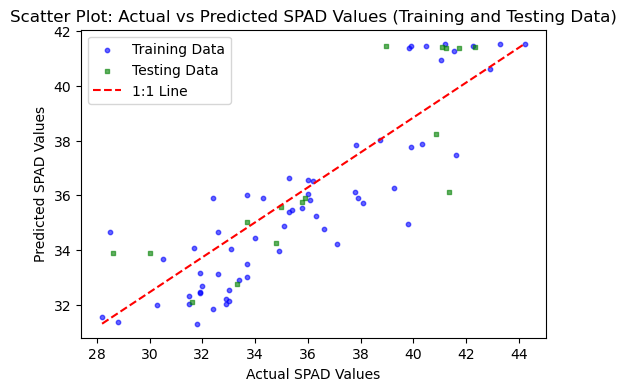

In [14]:
import matplotlib.pyplot as plt

# Assuming these are your actual and predicted SPAD values for both training and testing sets
y_train_actual = y_train # Replace with your actual training SPAD values
y_train_predicted = y_train_pred # Replace with your predicted SPAD values from the model (training)

y_test_actual = y_test  # Replace with your actual testing SPAD values
y_test_predicted = y_test_pred  # Replace with your predicted SPAD values from the model (testing)

# Combined Plot
plt.figure(figsize=(6, 4))

# Scatter plot for Training Data (circles)
plt.scatter(y_train_actual, y_train_predicted, color='blue', alpha=0.6, s=10, marker='o', label='Training Data')

# Scatter plot for Testing Data (squares)
plt.scatter(y_test_actual, y_test_predicted, color='green', alpha=0.6, s=10, marker='s', label='Testing Data')

# Plot the 1:1 line (perfect prediction)
plt.plot([min(min(y_train_actual), min(y_test_actual)), max(max(y_train_actual), max(y_test_actual))],
         [min(min(y_train_predicted), min(y_test_predicted)), max(max(y_train_predicted), max(y_test_predicted))],
         color='red', linestyle='--', label='1:1 Line')

# Labels and title
plt.xlabel('Actual SPAD Values', fontsize=10)
plt.ylabel('Predicted SPAD Values', fontsize=10)
plt.title('Scatter Plot: Actual vs Predicted SPAD Values (Training and Testing Data)', fontsize=12)

# Add legend
plt.legend()

# Remove grid and display plot
plt.show()



In [15]:
# Define parameter grids for RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [20,50,60,70],
    'learning_rate': [0.01, 0.1, 0.2, 0.7],
    'max_depth': [3, 6, 4, 5],
    'subsample': [0.5,0.3, 0.8, 0.2],
    'colsample_bytree': [0.5, 0.8, 1.0]
}
# Initialize models
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=175)
# Perform RandomizedSearchCV for each model
random_search_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_dist_xgb, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_xgb.fit(X_train_rfe, y_train)
best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)
# Cross-validation with the best hyperparameters for each model
mse_scores_xgb = cross_val_score(best_xgb, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_xgb = -mse_scores_xgb
average_mse_xgb = np.mean(mse_scores_xgb)
# Print cross-validation results
print(f"Average MSE for XGBoost: {average_mse_xgb}")


# Evaluate the individual models
models = {
      "XGBoost": best_xgb
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for XGBoost:  {'subsample': 0.5, 'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Average MSE for XGBoost: 6.732698007769547
Evaluating XGBoost model...
Training Metrics:
              MAE       MSE   Pearson        R2      RMSE       RPD
XGBoost  0.447977  0.375777  0.990422  0.975861  0.613006  6.436378

Testing Metrics:
              MAE       MSE   Pearson        R2      RMSE       RPD
XGBoost  1.737659  5.988247  0.841319  0.687092  2.447089  1.787689


In [16]:
# Define parameter grids for RandomizedSearchCV
param_dist_gb = {
    'n_estimators': [100,150,1300,1000],
    'learning_rate': [0.01, 0.1,1, 0.001],
    'max_depth': [3, 4, 7, 8]
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=48, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_rfe, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)
# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")
# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
    }
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Gradient Boosting:  {'n_estimators': 1300, 'max_depth': 3, 'learning_rate': 0.001}
Average MSE for Gradient Boosting: 6.677442082622403
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  1.438819  3.274292  0.940392  0.789668  1.809501  2.180458

Testing Metrics:
                      MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  2.08138  7.237452  0.826869  0.621817  2.690251  1.626106


In [17]:
# Define parameter grids for RandomizedSearchCV
param_dist_svr = {
    'C': [0.3,0.001,6,8],
    'epsilon': [0.1,0.001,1,0.02],
    'kernel': ['linear', 'rbf']
}
# Initialize models
model_svr = SVR()
# Perform RandomizedSearchCV for each model
random_search_svr = RandomizedSearchCV(model_svr, param_distributions=param_dist_svr, n_iter=32, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_svr.fit(X_train_rfe, y_train)
best_svr = random_search_svr.best_estimator_
best_params_svr = random_search_svr.best_params_
print("Best parameters for SVR: ", best_params_svr)
# Cross-validation with the best hyperparameters for each model
mse_scores_svr = cross_val_score(best_svr, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_svr = -mse_scores_svr
average_mse_svr = np.mean(mse_scores_svr)
# Print cross-validation results
print(f"Average MSE for SVR: {average_mse_svr}")
# Evaluate the individual models
models = {
    "SVR": best_svr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for SVR:  {'kernel': 'rbf', 'epsilon': 1, 'C': 6}
Average MSE for SVR: 7.381834004793722
Evaluating SVR model...
Training Metrics:
          MAE       MSE   Pearson        R2      RMSE       RPD
SVR  1.465836  3.742623  0.875848  0.759584  1.934586  2.039476

Testing Metrics:
          MAE       MSE   Pearson        R2      RMSE       RPD
SVR  1.530717  4.799742  0.878743  0.749196  2.190831  1.996792


In [18]:
# Define parameter grids for RandomizedSearchCV
param_dist_elnet = {
    'alpha': [0.01, 0.1, 1, 10,12],
    'l1_ratio': [0.01, 0.1,1,0.001,0.00001]
}
# Initialize models
model_elnet = ElasticNet(random_state=175) 
# Perform RandomizedSearchCV for each model
random_search_elnet = RandomizedSearchCV(model_elnet, param_distributions=param_dist_elnet, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_elnet.fit(X_train_rfe, y_train)
best_elnet = random_search_elnet.best_estimator_
best_params_elnet = random_search_elnet.best_params_
print("Best parameters for Elastic Net: ", best_params_elnet)
# Cross-validation with the best hyperparameters for each model
mse_scores_elnet = cross_val_score(best_elnet, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_elnet = -mse_scores_elnet
average_mse_elnet = np.mean(mse_scores_elnet)
# Print cross-validation results
print(f"Average MSE for Elastic Net: {average_mse_elnet}")
# Evaluate the individual models
models = {
    "ElasticNet": best_elnet
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Elastic Net:  {'l1_ratio': 1, 'alpha': 0.01}
Average MSE for Elastic Net: 6.857714257367505
Evaluating ElasticNet model...
Training Metrics:
                 MAE       MSE   Pearson        R2      RMSE       RPD
ElasticNet  1.836113  5.644844  0.799396  0.637391  2.375888  1.660659

Testing Metrics:
                 MAE       MSE   Pearson       R2      RMSE       RPD
ElasticNet  1.796718  5.927632  0.841021  0.69026  2.434673  1.796806


In [19]:
# Define parameter grids for RandomizedSearchCV

# Initialize models
model_plsr = PLSRegression(n_components=2) 

# Perform RandomizedSearchCV for each model
# PLSR does not require hyperparameter tuning here
best_plsr = model_plsr
best_plsr.fit(X_train_rfe, y_train)
# Cross-validation with the best hyperparameters for each model

mse_scores_plsr = cross_val_score(best_plsr, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_plsr = -mse_scores_plsr
average_mse_plsr = np.mean(mse_scores_plsr)
# Print cross-validation results
print(f"Average MSE for PLSR: {average_mse_plsr}")
# Evaluate the individual models
models = {
    "PLSR": best_plsr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Average MSE for PLSR: 6.98076121160018
Evaluating PLSR model...
Training Metrics:
           MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  1.852552  5.609059  0.799806  0.639689  2.368345  1.665948

Testing Metrics:
           MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  1.744888  5.855629  0.838834  0.694022  2.419841  1.807819


In [20]:
# Ensemble the models using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('svr', best_svr),
    ('elnet', best_elnet)
])

ensemble_model.fit(X_train_rfe, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_rfe)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_rfe))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      2.654996
RMSE     1.629416
MAE      1.207170
R2       0.829450
RPD      2.421445
Pearson  0.926913

Ensemble Model Testing Metrics:
         Ensemble
MSE      5.459958
RMSE     2.336655
MAE      1.644564
R2       0.714697
RPD      1.872178
Pearson  0.861842


In [21]:
# Ensemble the models using Voting Regressor # 2 the best model ensembled
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb)
])

ensemble_model.fit(X_train_rfe, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_rfe)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_rfe))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      1.475714
RMSE     1.214790
MAE      0.885272
R2       0.905204
RPD      3.247921
Pearson  0.959487

Ensemble Model Testing Metrics:
         Ensemble
MSE      5.473010
RMSE     2.339446
MAE      1.592422
R2       0.714015
RPD      1.869944
Pearson  0.856743
